In [1]:
import numpy as np
import matplotlib.pyplot as plt
from base_model_utils import import_scaled_data
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import os

In [47]:
def celcius_to_kelvin(list_of_celcius):
    return list_of_celcius + 273.15

In [49]:
from base_model_utils import load_data_from_csv

# get data
unscaled_data = load_data_from_csv("75e9_2023_09_07_11_02_to_2023_09_13_11_02.csv")
unscaled_data = unscaled_data[:, np.newaxis]

# find rescaling function
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit_transform(unscaled_data)

# for each file in /output
directory = "./output"
for filename in os.listdir(directory):
    if filename.endswith('.npz'):
        # Load the .npy file
        file_path = os.path.join(directory, filename)
        scaled_data = np.load(file_path)

        # preds
        preds = scaled_data["preds"]
        preds = scaler.inverse_transform(preds)
        preds = celcius_to_kelvin(preds)
        
        # weights
        weights = scaled_data["weights"]
        
        # bm_1
        bm_1 = scaled_data["bm_1"]
        bm_1 = scaler.inverse_transform(bm_1)
        bm_1 = celcius_to_kelvin(bm_1)
        
        # bm_2
        bm_2 = scaled_data["bm_2"]
        bm_2 = scaler.inverse_transform(bm_2)
        bm_2 = celcius_to_kelvin(bm_2)

        # # save to /rescaled_output
        file_path = os.path.join("./scaled-output", filename)
        np.savez(file_path,
             preds=preds,
             weights=weights,
             bm_1=bm_1,
             bm_2=bm_2
             )


In [58]:
def get_data(seedling):
    # import reading data
    data = load_data_from_csv("75e9_2023_09_07_11_02_to_2023_09_13_11_02.csv")
    data = celcius_to_kelvin(data)

    # import prediction data
    prediction_data = np.load(f'scaled-output/data_{seedling}.npz')
    preds = prediction_data['preds']
    weights = prediction_data['weights']
    bm_1 = prediction_data['bm_1']
    bm_2 = prediction_data['bm_2']

    # fix length
    length = min([len(l) for l in [data, preds, weights, bm_1, bm_2]])
    length = length - 2993
    data = data[-length:]
    preds = preds[-length:, 0]
    weights = weights[-length:]
    bm_2 = bm_2[-length:, 0]
    bm_1 = bm_1[-length:, 0]

    return data, preds, weights, bm_1, bm_2


In [73]:
bm_1_total_data = []
bm_2_total_data = []
pred_total_data = []
pred_control_total_data = []

for i in range(20):
    # get the base model data from the first 20
    data, preds, weights, bm_1, bm_2 = get_data(i)
    bm_1_total_data.append(bm_1)
    bm_2_total_data.append(bm_2)
    pred_control_total_data.append(preds)
    
    # get the meta model predictions from the second 20
    data, preds, weights, bm_1, bm_2 = get_data(i+20)
    pred_total_data.append(preds)

bm_1_total_data = np.array(bm_1_total_data)
bm_2_total_data = np.array(bm_2_total_data)
pred_total_data = np.array(pred_total_data)
pred_control_total_data = np.array(pred_control_total_data)

bm_1_total_data.shape, bm_2_total_data.shape, pred_total_data.shape

((20, 1240), (20, 1240), (20, 1240))

In [60]:
def graph_multi_hist_across_all_data():
    plt.figure(figsize=(12, 8))

    cum_bm_1 = []
    cum_bm_2 = []
    cum_preds = []
    
    for idx in range(20):
        # use first 20 for base models
        data, preds, weights, bm_1, bm_2 = get_data(idx)
        
        # Calculate errors
        mae = mean_absolute_error(data, bm_1)
        cum_bm_1.append(mae)
        
        mae = mean_absolute_error(data, bm_2)
        cum_bm_2.append(mae)

        # use second 20 for meta preds
        data, preds, weights, bm_1, bm_2 = get_data(idx+20)
        
        mae = mean_absolute_error(data, preds)
        cum_preds.append(mae)

    # Determine the common range for all histograms
    all_data = np.concatenate((cum_bm_1, cum_bm_2, cum_preds))
    min_bin = np.min(all_data)
    max_bin = np.max(all_data)
    
    # Define the common bin edges
    bins = np.linspace(min_bin, max_bin, 60)
    
    # Histogram of Forecast Errors
    plt.hist(cum_bm_1, bins=bins, label="bm_1", edgecolor='black', alpha=0.5)
    plt.hist(cum_bm_2, bins=bins, label="bm_2",  edgecolor='black', alpha=0.5)
    plt.hist(cum_preds, bins=bins, label="preds",  edgecolor='black', alpha=0.5)
    
    plt.title('Histogram of Forecast MAE')
    plt.xlabel('Mean Average Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


In [61]:
def get_cv(all_data):
    coef_of_var = []
    
    for idx in range(1240):
        temp = all_data[:, idx]
    
        var = np.var(temp)
        std = np.std(temp)
        mean = np.mean(temp)
    
        cv = std / mean
        
        coef_of_var.append(cv)
    
    coef_of_var = np.array(coef_of_var)

    return coef_of_var


In [76]:
def plot_data_directly():
    data, preds, weights, bm_1, bm_2 = get_data(0)
    
    fig, ax1 = plt.subplots()
    x = range(len(data))
    
    # labeling
    ax1.plot(x, data, label="data", color='black')  
    ax1.plot(x, bm_1, label="bm_1", color='blue')  
    ax1.plot(x, bm_2, label="bm_2", color='green')  
    ax1.plot(x, preds, label="preds", color='red')  
    ax1.set_xlabel('Time steps')
    ax1.set_ylabel('Degrees Kelvin')

    # Creating a second y-axis on the right and plotting the second dataset
    ax2 = ax1.twinx()
    ax2.plot(x, weights[:, 0], label="bm_1:bm_2", color='gray') 
    ax2.set_ylabel('Weights')
    
    # Display the plot
    ax1.legend()
    ax2.legend()
    plt.show()

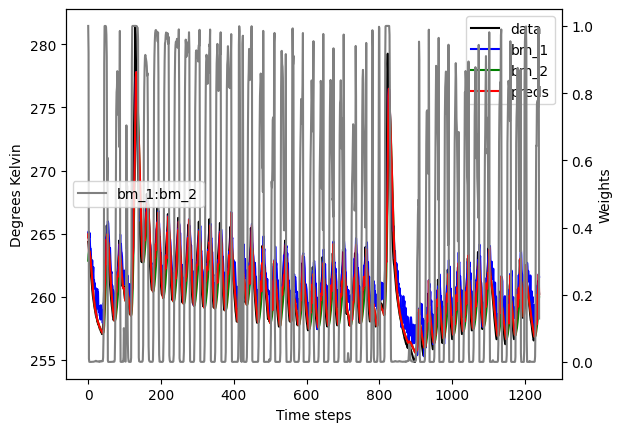

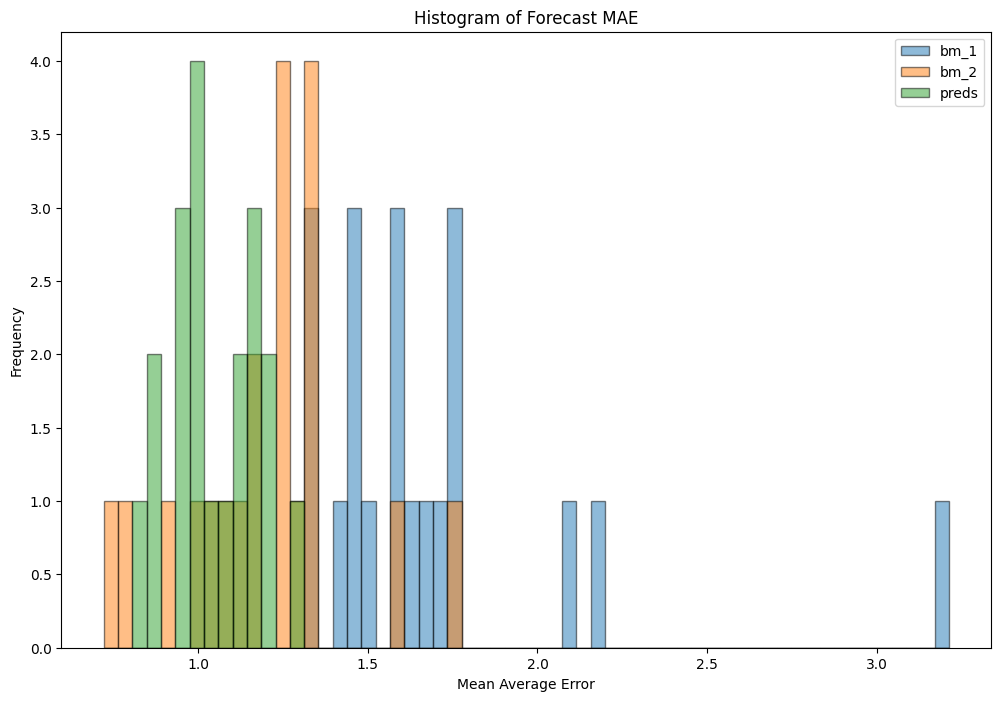

In [77]:
# PLOT HISTOGRAMS OF MAE
plot_data_directly()
graph_multi_hist_across_all_data()

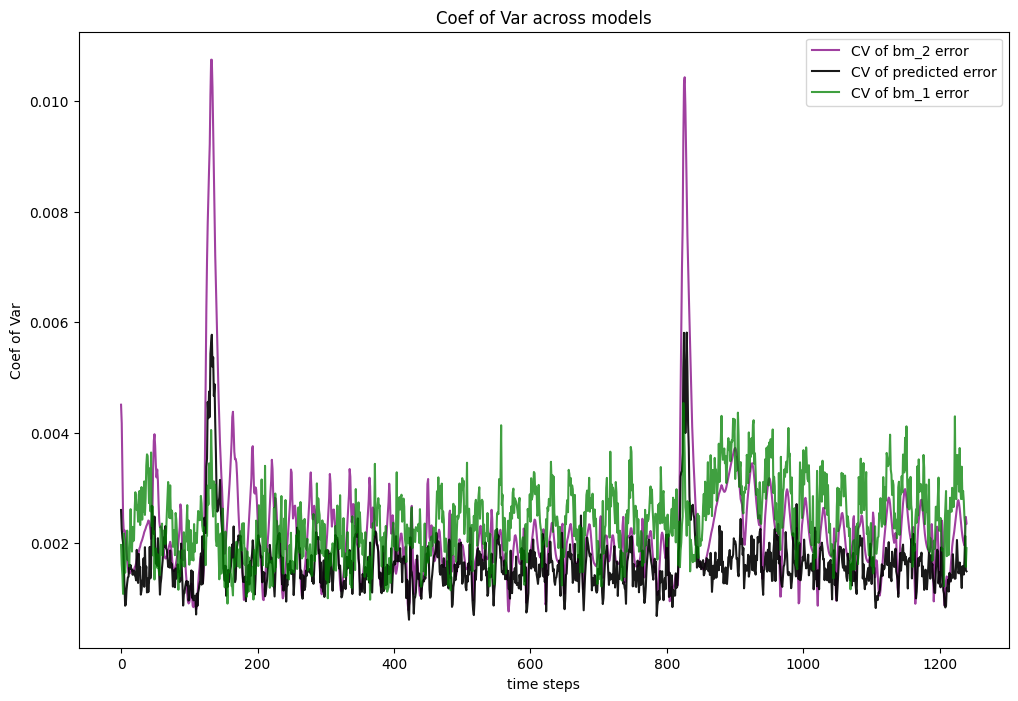

In [75]:
# PLOT COEF OF VAR
plt.figure(figsize=(12, 8))

plt.plot(get_cv(bm_2_total_data), label="CV of bm_2 error", color='purple', alpha=0.75)
plt.plot(get_cv(pred_total_data), label="CV of predicted error", color='black', alpha=0.9)
plt.plot(get_cv(bm_1_total_data), label="CV of bm_1 error", color='green', alpha=0.75)
plt.legend()
plt.xlabel('time steps')
plt.ylabel('Coef of Var')
plt.title('Coef of Var across models')

# Display the plot
plt.show()
    

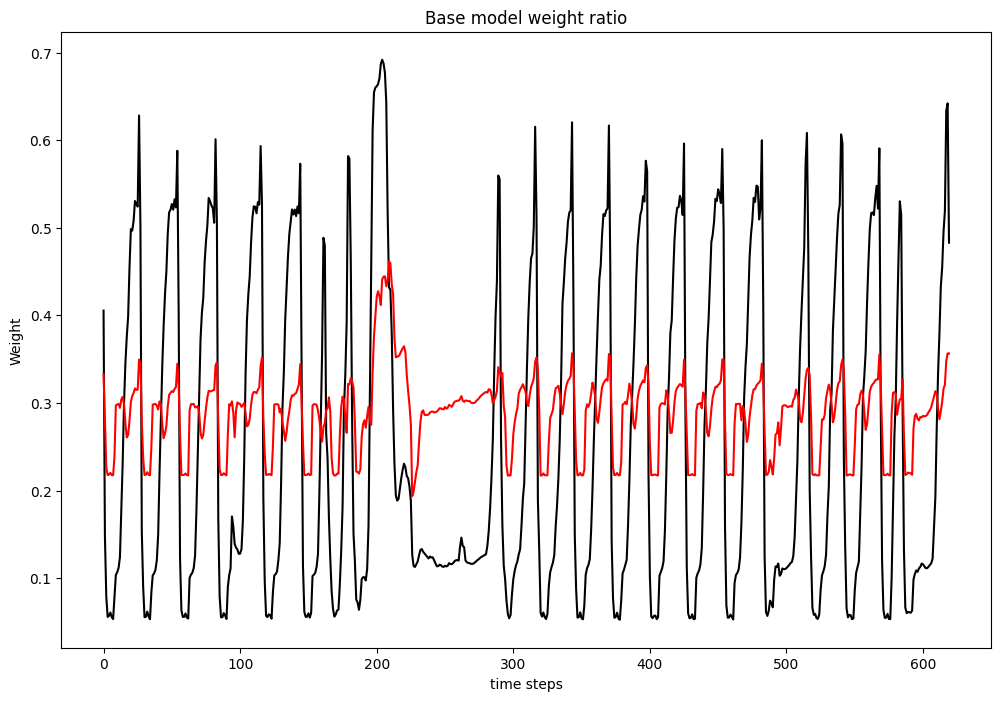

In [10]:
cum_weights = []

for idx in range(20):
    # use second 20 for meta preds
    _, _, weights, _, _ = get_data(idx+20)
    cum_weights.append(weights[:, 0, 0])

cum_weights = np.array(cum_weights)

cum_weights_avg = np.mean(cum_weights, axis=0)

plt.figure(figsize=(12, 8))

length = len(cum_weights_avg) // 2

plt.plot(cum_weights_avg[-length:], label="bm_1:bm_2", color='black')
plt.plot(get_cv(cum_weights)[-length:], label="CV of bm_1:bm_2", color='red')
plt.xlabel('time steps')
plt.ylabel('Weight')
plt.title('Base model weight ratio')

# Display the plot
plt.show()